# 开发 AI 应用

未来，AI 算法在日常生活中的应用将越来越广泛。例如，你可能想要在智能手机应用中包含图像分类器。为此，在整个应用架构中，你将使用一个用成百上千个图像训练过的深度学习模型。未来的软件开发很大一部分将是使用这些模型作为应用的常用部分。

在此项目中，你将训练一个图像分类器来识别不同的花卉品种。可以想象有这么一款手机应用，当你对着花卉拍摄时，它能够告诉你这朵花的名称。在实际操作中，你会训练此分类器，然后导出它以用在你的应用中。我们将使用[此数据集](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)，其中包含 102 个花卉类别。你可以在下面查看几个示例。 

<img src='assets/Flowers.png' width=500px>

该项目分为多个步骤：

* 加载和预处理图像数据集
* 用数据集训练图像分类器
* 使用训练的分类器预测图像内容

我们将指导你完成每一步，你将用 Python 实现这些步骤。

完成此项目后，你将拥有一个可以用任何带标签图像的数据集进行训练的应用。你的网络将学习花卉，并成为一个命令行应用。但是，你对新技能的应用取决于你的想象力和构建数据集的精力。例如，想象有一款应用能够拍摄汽车，告诉你汽车的制造商和型号，然后查询关于该汽车的信息。构建你自己的数据集并开发一款新型应用吧。

首先，导入你所需的软件包。建议在代码开头导入所有软件包。当你创建此 notebook 时，如果发现你需要导入某个软件包，确保在开头导入该软件包。

In [1]:
# 魔法命令
%matplotlib inline

# 导入各库
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from collections import OrderedDict
from torch import nn
from torch import optim
from PIL import Image
from torch.autograd import Variable

## 加载数据

在此项目中，你将使用 `torchvision` 加载数据（[文档](http://pytorch.org/docs/master/torchvision/transforms.html#)）。数据应该和此 notebook 一起包含在内，否则你可以[在此处下载数据](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)。数据集分成了三部分：训练集、验证集和测试集。对于训练集，你需要变换数据，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。你还需要确保将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这么做。

验证集和测试集用于衡量模型对尚未见过的数据的预测效果。对此步骤，你不需要进行任何缩放或旋转变换，但是需要将图像剪裁到合适的大小。

对于所有三个数据集，你都需要将均值和标准差标准化到网络期望的结果。均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [2]:
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

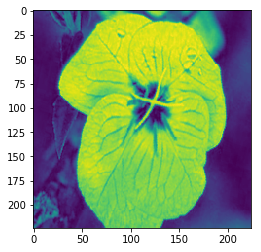

In [3]:
# 1.DONE: Define your transforms for the training, validation, and testing sets
# 1.1 训练集变换设定:随机旋转;裁切到224*224;随机水平翻转;随机垂直翻转;转换成张量;正则化
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
# 1.2 验证集变换设定：缩放至256*256再裁切到224*224；转换成张量；正则化 这里有些疑惑？
# 看Part8 Transfer Learning 的 solution中 这里进行了缩放到256*256再裁切224*224
# 到底要不要缩放呢？我觉得是需要，因为有可能裁切到一些没有物体的地方，或者物体只有部分
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
# 1.3 测试集变换设定：同验证集
test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


# 2.DONE: 加载图像
image_datasets = datasets.ImageFolder('../aipnd-project/flowers/' + train_dir, 
                                      transform=train_transforms)
valid_datasets = datasets.ImageFolder('../aipnd-project/flowers/' + valid_dir,
                                      transform=valid_transforms)
test_datasets = datasets.ImageFolder('../aipnd-project/flowers/' + test_dir,
                                      transform=test_transforms)


# 3.DONE: Using the image datasets and the trainforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=True)
validloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=10, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_datasets, batch_size=10, shuffle=True)


# 4.简单检查是否正确加载
images, labels = next(iter(image_datasets))
plt.imshow(images[2])

### 标签映射

你还需要加载从类别标签到类别名称的映射。你可以在文件 `cat_to_name.json` 中找到此映射。它是一个 JSON 对象，可以使用 [`json` 模块](https://docs.python.org/2/library/json.html)读取它。这样可以获得一个从整数编码的类别到实际花卉名称的映射字典。

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

数据准备好后，就开始构建和训练分类器了。和往常一样，你应该使用 `torchvision.models` 中的某个预训练模型获取图像特征。使用这些特征构建和训练新的前馈分类器。

这部分将由你来完成。如果你想与他人讨论这部分，欢迎与你的同学讨论！你还可以在论坛上提问或在工作时间内咨询我们的课程经理和助教导师。

请参阅[审阅标准](https://review.udacity.com/#!/rubrics/1663/view)，了解如何成功地完成此部分。你需要执行以下操作：

* 加载[预训练的网络](http://pytorch.org/docs/master/torchvision/models.html)（如果你需要一个起点，推荐使用 VGG 网络，它简单易用）
* 使用 ReLU 激活函数和丢弃定义新的未训练前馈网络作为分类器
* 使用反向传播训练分类器层，并使用预训练的网络获取特征
* 跟踪验证集的损失和准确率，以确定最佳超参数

我们在下面为你留了一个空的单元格，但是你可以使用多个单元格。建议将问题拆分为更小的部分，并单独运行。检查确保每部分都达到预期效果，然后再完成下个部分。你可能会发现，当你实现每部分时，可能需要回去修改之前的代码，这很正常！

训练时，确保仅更新前馈网络的权重。如果一切构建正确的话，验证准确率应该能够超过 70%。确保尝试不同的超参数（学习速率、分类器中的单元、周期等），寻找最佳模型。保存这些超参数并用作项目下个部分的默认值。

In [5]:
# DONE: 创建神经网络
# 加载预训练网络 这里采用VGG16
model = models.vgg16(pretrained=True)

# 更改分类器
# 将分类器前所有的参数进行冻结 仅更改最后的分类器
for param in model.parameters():
    param.requires_grad = False
# 设计分类器 使用LogSoftmax最终激活
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('0', nn.Linear(25088, 4096, bias=True)),
    ('1', nn.ReLU(inplace=True)),
    ('2', nn.Dropout(p=0.5)),
    ('3', nn.Linear(4096, 4096, bias=True)),
    ('4', nn.ReLU(inplace=True)),
    ('5', nn.Dropout(p=0.5)),
    ('6', nn.Linear(4096, 102, bias=True)),
    ('output', nn.LogSoftmax(dim=1))
    ]))
# 将VGG16最后分类器改成自己设计的 并且观察一下是否更改成功
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
# DONE 训练有新分类器的预先训练好的神经网络 
# 不知道为什么loss很大...在命令行那个里面就很小？可能是数据量的问题嘛？
# 那个数据量比这里多多了，这里每个类就1张图片...猜测容易欠拟合或者过拟合

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0003)

epochs = 8
print_every = 50
steps = 0

# 使用GPU进行训练
model.cuda()

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(dataloaders):
        model.train() # 置于train模式
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        optimizer.step()
        # 计算损失
        running_loss += loss.item()
        # 打印结果
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            # 损失置零
            running_loss = 0
    # 用验证集在每个Epoch结束之后 用验证集 验证准确率
    # 参考：验证集的作用 https://www.jianshu.com/p/7e032a8aaad5
    model.eval() # 推理模式
    correct = 0
    total = 0
    with torch.no_grad():
        # 不传播梯度 仅用于验证
        for ii, (inputs, labels) in enumerate(validloaders):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs_valid = model(inputs)
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = (100 * correct / total)
        print("本epoch结束后，验证准确率为：%d %%" % acc)     

Epoch: 1/8...  Loss: 4.9091
Epoch: 1/8...  Loss: 4.3663
Epoch: 1/8...  Loss: 3.8857
Epoch: 1/8...  Loss: 3.4453
Epoch: 1/8...  Loss: 3.2589
Epoch: 1/8...  Loss: 2.8451
Epoch: 1/8...  Loss: 2.8905
Epoch: 1/8...  Loss: 2.6567
Epoch: 1/8...  Loss: 2.6339
Epoch: 1/8...  Loss: 2.3939
Epoch: 1/8...  Loss: 2.4829
Epoch: 1/8...  Loss: 2.4057
Epoch: 1/8...  Loss: 2.3839
本epoch结束后，验证准确率为：61 %
Epoch: 2/8...  Loss: 2.1308
Epoch: 2/8...  Loss: 2.3646
Epoch: 2/8...  Loss: 2.1095
Epoch: 2/8...  Loss: 1.9518
Epoch: 2/8...  Loss: 2.0743
Epoch: 2/8...  Loss: 2.1047
Epoch: 2/8...  Loss: 2.1218
Epoch: 2/8...  Loss: 2.0845
Epoch: 2/8...  Loss: 1.9650
Epoch: 2/8...  Loss: 2.0778
Epoch: 2/8...  Loss: 1.8681
Epoch: 2/8...  Loss: 1.9762
Epoch: 2/8...  Loss: 2.0367
本epoch结束后，验证准确率为：70 %
Epoch: 3/8...  Loss: 1.5667
Epoch: 3/8...  Loss: 1.7850
Epoch: 3/8...  Loss: 1.7993
Epoch: 3/8...  Loss: 1.7687
Epoch: 3/8...  Loss: 1.8552
Epoch: 3/8...  Loss: 2.0015
Epoch: 3/8...  Loss: 1.7541
Epoch: 3/8...  Loss: 1.8841
Epoc

## 测试网络

建议使用网络在训练或验证过程中从未见过的测试数据测试训练的网络。这样，可以很好地判断模型预测全新图像的效果。用网络预测测试图像，并测量准确率，就像验证过程一样。如果模型训练良好的话，你应该能够达到大约 70% 的准确率。

In [8]:
# DONE: Do validation on the test set
def test_model():
    '''
    测试网络函数test_model(),用于测试神经网络并且打印出在102张测试图片中的预测准确率。
    参数：void
    返回：void
    '''
    model.eval() # 模型置于evaluation模式
    correct = 0
    total = 0
    with torch.no_grad():
        # 不传播梯度
        for data in testloaders:
            images, labels = data
            # 这里要将images和labels丢到GPU中去 否则会出问题
            # 参考了 https://stackoverflow.com/questions/53156298/expected-object-of-type-torch-floattensor-but-found-type-torch-cuda-floattensor
            images = images.cuda()
            labels = labels.cuda()
            # 测试
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # 打印结果
        acc = (100.0 * correct / total)
        print('在测试图片中，本模型准确率达到：%.2f %%' % acc)
        
# 调用测试函数
test_model()

在测试图片中，本模型准确率达到：82.17 %


## 保存检查点

训练好网络后，保存模型，以便稍后加载它并进行预测。你可能还需要保存其他内容，例如从类别到索引的映射，索引是从某个图像数据集中获取的：`image_datasets['train'].class_to_idx`。你可以将其作为属性附加到模型上，这样稍后推理会更轻松。

In [ ]:
# DONE: Save the checkpoint 
# 这块保存有点小懵？？？参考了Part6部分 应该是不光要但保存超参数 还要保存模型的其他信息
# VGG16模型的输入的尺寸是多少? 参考了：https://blog.csdn.net/errors_in_life/article/details/65950699
# VGG16输入的尺寸也参考了后面要将图片改为3*224*224矩阵 猜测是[3, 224, 224]
# 不过后面发现输入3*224*224好像不行 得加一个维度变成1*3*224*224 似乎是丢失了维度？
# 然后class_to_idx映射是否也作为模型的其他信息保存在这个checkpoint字典中？？？
# 这块不是很懂，先保存了再说...
# 到底应该保存一些啥？？？很疑惑 害怕会漏掉一些超参数或者其他信息

model_class_to_idx = image_datasets.class_to_idx

def save_checkpoint(model):
    checkpoint = {'input_size': [3, 224, 224],
                  'output_size': 102,
                 'batch_size': 10,
                 'epochs': 8,
                 'class_to_idx': model_class_to_idx,
                 'state_dict': model.state_dict(),
                 'optimizer_dict': optimizer.state_dict(),
                 'classifier': classifier
                 }
    torch.save(checkpoint, 'my_checkpoint.pth')
    
save_checkpoint(model)

In [ ]:
model.state_dict();

## 加载检查点

此刻，建议写一个可以加载检查点并重新构建模型的函数。这样的话，你可以回到此项目并继续完善它，而不用重新训练网络。

In [ ]:
# DONE: Write a function that loads a checkpoint and rebuilds the model 
# 保存和加载这块有点懵...加载即要重新构建模型+加载模型的一些信息包括权重和之前说的
# 标签的映射等？这样理解是否正确？
def load_checkpoint(filepath='my_checkpoint.pth'):
    checkpoint = torch.load(filepath) 
    # 重建模型 加载了vgg 自己设计的分类器 训练好的权重 标签映射 其他东西要不要加载？
    model = models.vgg16()
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    # 返回模型
    return model

# 加载一个new_model
new_model = load_checkpoint()
new_model;

# 类别推理

现在，你需要写一个使用训练的网络进行推理的函数。即你将向网络中传入一个图像，并预测图像中的花卉类别。写一个叫做 `predict` 的函数，该函数会接受图像和模型，然后返回概率在前 $K$ 的类别及其概率。应该如下所示：

In [ ]:
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

首先，你需要处理输入图像，使其可以用于你的网络。

## 图像处理

你需要使用 `PIL` 加载图像（[文档](https://pillow.readthedocs.io/en/latest/reference/Image.html)）。建议写一个函数来处理图像，使图像可以作为模型的输入。该函数应该按照训练的相同方式处理图像。

首先，调整图像大小，使最小的边为 256 像素，并保持宽高比。为此，可以使用 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 或 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 方法。然后，你需要从图像的中心裁剪出 224x224 的部分。

图像的颜色通道通常编码为整数 0-255，但是该模型要求值为浮点数 0-1。你需要变换值。使用 Numpy 数组最简单，你可以从 PIL 图像中获取，例如 `np_image = np.array(pil_image)`。

和之前一样，网络要求图像按照特定的方式标准化。均值应标准化为 `[0.485, 0.456, 0.406]`，标准差应标准化为 `[0.229, 0.224, 0.225]`。你需要用每个颜色通道减去均值，然后除以标准差。

最后，PyTorch 要求颜色通道为第一个维度，但是在 PIL 图像和 Numpy 数组中是第三个维度。你可以使用 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html)对维度重新排序。颜色通道必须是第一个维度，并保持另外两个维度的顺序。

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # DONE: Process a PIL image for use in a PyTorch model
    # 调整图像大小 使用thumbnail方法
    # 自己测试了一下 好像不会在原地更改 
    image.thumbnail((256, 256))
    # 裁切出中心224*224部分 使用crop方法 这里用image1作临时变量
    # 参考 https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.Image.resize
    # 四个参数组成元组 分别是起始点横坐标,纵坐标（到左侧，上侧）；终点（对角那个）的横坐标，纵坐标（到左侧，上策的距离）
    image1 = image.crop((16,16,240,240))
    # 将PIL image 转换成array 并变成0-1 参考 https://www.cnblogs.com/changbaishan/p/8432786.html
    np_image = np.array(image1) / 255
    # 进行标准化 每个通道减去均值 并除以标准差
    np_image[:,:,0] = (np_image[:,:,0] - 0.485) / 0.229;
    np_image[:,:,1] = (np_image[:,:,1] - 0.456) / 0.224;
    np_image[:,:,2] = (np_image[:,:,2] - 0.406) / 0.225;
    # 维度顺序更改 参考了：http://www.cnblogs.com/sunshinewang/p/6893503.html
    # 理解成索引更方便 第一个维度 的索引是0 第二个维度索引是1 ...
    # 这里是224*224*3 三维矩阵 然后颜色是那个3 即将第三个维度的索引变成0 其他不变
    pytorch_np_image = np_image.transpose((2,0,1))
    # 话说返回的np array可以直接放到模型中嘛...不应该转成Tensor嘛
    return pytorch_np_image

要检查你的项目，可以使用以下函数来转换 PyTorch 张量并将其显示在  notebook 中。如果 `process_image` 函数可行，用该函数运行输出应该会返回原始图像（但是剪裁掉的部分除外）。

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# 调用imshow查看
imshow(images)

## 类别预测

可以获得格式正确的图像后 

要获得前 $K$ 个值，在张量中使用 [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk)。该函数会返回前 `k` 个概率和对应的类别索引。你需要使用  `class_to_idx`（希望你将其添加到了模型中）将这些索引转换为实际类别标签，或者从用来加载数据的[ `ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)进行转换。确保颠倒字典

同样，此方法应该接受图像路径和模型检查点，并返回概率和类别。

In [ ]:
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # DONE: Implement the code to predict the class from an image file
    model.eval() # 推理模式
    model.cpu() # 丢到GPU中
    # 获取并处理图片 并且将图片转为Tensor
    image = torch.FloatTensor(process_image(Image.open(image_path)))
    # 这里试了半天 参考了 https://discuss.pytorch.org/t/expected-stride-to-be-a-single-integer-value-or-a-list-of-1-values-to-match-the-convolution-dimensions-but-got-stride-1-1/17140
    # 多增加一个维度？？让我有点小懵？输入不是3*224*224嘛 为什么变成1*3*224*224
    # 根据上面那个回答好像是丢失了第一个维度？不是很明白这块，希望能够解答！谢谢
    a = Variable(image).cpu()
    a = a.unsqueeze(0)
    # 前向计算 使用forward报错...似乎是cpu gpu问题 这里就采用cpu计算
    with torch.no_grad():
        output = new_model.forward(a)
        top_prob, top_labels = torch.topk(output, topk)
        # 做指数运算
        top_prob = top_prob.exp()
    # 取出索引表
    class_to_idx_inv = {new_model.class_to_idx[k]: k for k in new_model.class_to_idx}
    mapped_classes = list()
    # 遍历labels
    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])
        
    return top_prob.numpy()[0], mapped_classes


# 测试一下 调用之前加载后的new_model
probs, classes = predict('../aipnd-project/flowers/valid/10/image_07101.jpg', new_model)
print(probs)
print(classes)

## 检查运行状况

你已经可以使用训练的模型做出预测，现在检查模型的性能如何。即使测试准确率很高，始终有必要检查是否存在明显的错误。使用 `matplotlib` 将前 5 个类别的概率以及输入图像绘制为条形图，应该如下所示：

<img src='assets/inference_example.png' width=300px>

你可以使用 `cat_to_name.json` 文件（应该之前已经在 notebook 中加载该文件）将类别整数编码转换为实际花卉名称。要将 PyTorch 张量显示为图像，请使用定义如下的 `imshow` 函数。

In [ ]:
# DONE: Display an image along with the top 5 classes
# 从验证集中取出一张图片
valid_img_path = 'flowers/valid/23/image_03437.jpg'
valid_img_sample = Image.open(valid_img_path)
# 预测运算 取出top5的类别名和概率
probs, class_idx = predict(valid_img_path, new_model)
# 用映射来讲idx变成实际名称
class_names = [cat_to_name[i] for i in class_idx]
# 建立字典和DataFrame
items = {'name': pd.Series(data = class_names),
        'probability': pd.Series(data = probs)}
res = pd.DataFrame(items)

# 绘制图片
# 参考了：https://github.com/cjimti/aipnd-project/blob/master/Image%20Classifier%20Project.ipynb
# 参考了：https://github.com/rajesh-iiith/AIPND-ImageClassifier/blob/master/Image%20Classifier%20Project.ipynb
# 参考了: https://blog.csdn.net/changzoe/article/details/78845756
plt.figure()
fig = plt.figure(figsize=(5, 5))
sp_img = plt.subplot2grid((12,9), (0,0), colspan=9, rowspan=8)
sp_prd = plt.subplot2grid((12,9), (9,2), colspan=5, rowspan=5)
# 花卉图片
sp_img.imshow(valid_img_sample)
# 概率条形图
y_pos = np.arange(len(res['probability'])) # 对y进行排序
sp_prd.barh(y_pos, res['probability'])
sp_prd.set_yticks(y_pos) 
sp_prd.set_yticklabels(res['name'])
sp_prd.set_xlabel('Probability')
sp_prd.invert_yaxis() # 将y的值反转 不然是从小到大